In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import numpy as np
import seaborn as sns
import re
import os
import sys
import subprocess
import logging
import itertools
from collections import defaultdict
from IPython.display import HTML, Image, display


import ipywidgets as widgets

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S', stream=sys.stdout)
##
sns.set(style="darkgrid", font_scale=1.2)
print("numpy {}, pandas {}, seaborn: {}".format(
    np.__version__, pd.__version__, sns.__version__
))

numpy 1.18.5, pandas 1.1.1, seaborn: 0.10.0


# load data

In [3]:
DATA_DIR = "data"

In [37]:
items = pd.read_csv(os.path.join(DATA_DIR, 'items.csv'))
shops = pd.read_csv(os.path.join(DATA_DIR, 'shops.csv'))
item_cats = pd.read_csv(os.path.join(DATA_DIR, 'item_categories.csv'))
train = pd.read_csv(os.path.join(DATA_DIR, 'sales_train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

In [15]:
len(items), len(shops), len(item_cats), len(train), len(test)

(22170, 60, 84, 2935849, 214200)

In [5]:
train.sample(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2468652,21.02.2015,25,28,1858,1199.0,1.0
769819,14.08.2013,7,57,3673,1249.0,1.0
555386,25.06.2013,5,31,19719,119.0,1.0
2582434,04.04.2015,27,48,15278,1099.0,1.0
1882885,25.08.2014,19,31,17203,99.0,1.0
2624093,21.05.2015,28,16,1905,249.0,2.0
845981,12.09.2013,8,42,5821,599.0,1.0
2460493,22.02.2015,25,3,9396,299.0,1.0
2672219,14.06.2015,29,31,10093,399.0,2.0
1466903,15.03.2014,14,46,18545,149.0,1.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [8]:
# null checking
train.isnull().sum()


date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

# Monthly Sales

In [9]:
# convert the date column to datetime object
train["date"] = pd.to_datetime(train["date"], format = "%d.%m.%Y")

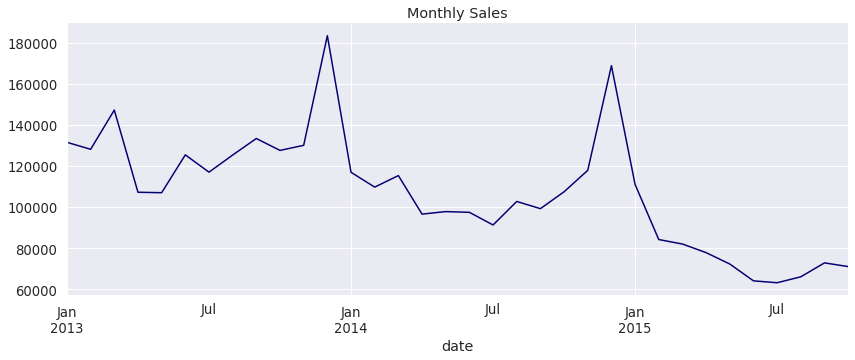

In [14]:
# resample the data on a monthly basis
train.set_index("date")['item_cnt_day'].resample("M").sum() \
     .plot(kind='line', color=sns.xkcd_rgb['deep blue'], figsize=(14, 5), rot=0)\
     .set(title='Monthly Sales')
sns.despine()
plt.show()

This figure shows the overall monthly sales happening across all shops and items. Observation:
* we see big spikes in the holiday season before January
* there is a general downward trend in the entire time span

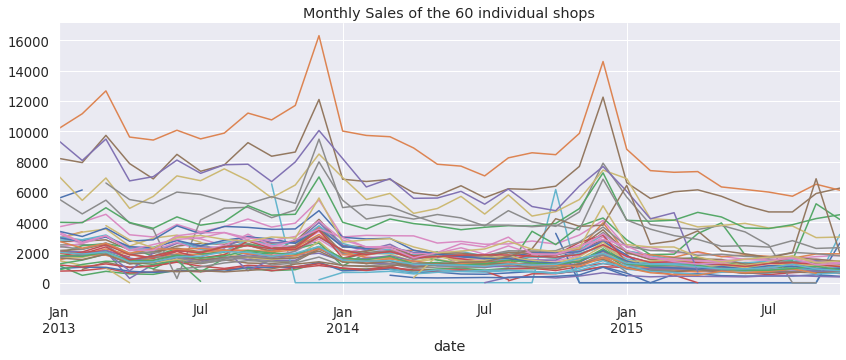

In [27]:
train.set_index("date").groupby('shop_id')['item_cnt_day'].resample("M").sum() \
     .unstack(level=0) \
     .plot(kind='line', figsize=(14, 5), rot=0, legend=False) \
     .set(title='Monthly Sales of the 60 individual shops')
sns.despine()
plt.show()

This figure shows the monthly sales of the 60 individual shops. Each line represents one shop. Observation:

* each shop more or less follows the general trend we observe above, with a few exceptions
* majority of the shops have low sales compared to a few with large volume of sales

In [38]:
train = pd.merge(train, items, on=['item_id'], how='left')
train = pd.merge(train, item_cats, on=['item_category_id'], how='left')

In [39]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


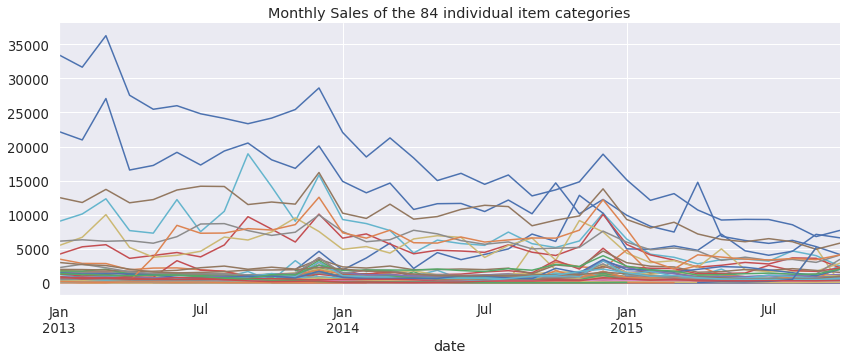

In [41]:
train.set_index("date").groupby('item_category_id')['item_cnt_day'].resample("M").sum() \
     .unstack(level=0) \
     .plot(kind='line', figsize=(14, 5), rot=0, legend=False) \
     .set(title='Monthly Sales of the 84 individual item categories')
sns.despine()
plt.show()

This figure shows the monthly sales of the 84 individual item categories. Each line represents one item category. Observations:

* each category has a downward overall trend in the time span
* majority of the categories have low sales compared to a few with large volume of sales